In [1]:
import numpy as np
import torch
from tqdm import tqdm

from PD.bias_registry import BiasRegistry
from models.sfcn_original import SFCN
from utils.datasets import TorchDataset as TD
from torch.utils.data import DataLoader

In [2]:
@torch.no_grad()
def test(model, test_path, bias_idx, class_idx):
    batch_size = 8
    test_loader = DataLoader(TD(test_path), batch_size=batch_size, shuffle=False)

    model.eval()
    y_true = []
    y_pred = []

    for batch in tqdm(test_loader, desc='Test'):
        x = batch[0].to('cuda')
        y_true += 1* (batch[bias_idx]==class_idx).cpu().tolist()
        y_pred += torch.sigmoid(model(x)).detach().cpu().tolist()

    return y_true, y_pred

In [3]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_auroc_curve(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    
    print('AUC: ', roc_auc)

    # Create the plot
    plt.figure(figsize=(10, 8))
    plt.plot(
        fpr,
        tpr,
        color='darkorange',
        lw=2,
        label=f'ROC curve (AUC = {roc_auc:.2f})'
    )
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')

    # Customize the plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    
    return roc_auc

## Trained model

Test: 100%|██████████| 21/21 [00:04<00:00,  4.87it/s]


AUC:  0.6879370629370629


Test: 100%|██████████| 21/21 [00:04<00:00,  4.92it/s]


AUC:  0.8704273504273504


Test: 100%|██████████| 21/21 [00:04<00:00,  4.88it/s]


AUC:  0.5811912225705329


Test: 100%|██████████| 21/21 [00:04<00:00,  4.95it/s]


AUC:  0.8074561403508772


Test: 100%|██████████| 21/21 [00:04<00:00,  4.89it/s]


AUC:  0.6588050314465409


Test: 100%|██████████| 21/21 [00:04<00:00,  4.89it/s]


AUC:  0.5668073136427566


Test: 100%|██████████| 21/21 [00:04<00:00,  4.99it/s]


AUC:  0.9005376344086021


Test: 100%|██████████| 21/21 [00:04<00:00,  4.97it/s]


AUC:  0.7169811320754716


Test: 100%|██████████| 21/21 [00:04<00:00,  5.00it/s]


AUC:  0.5988620199146515


Test: 100%|██████████| 21/21 [00:04<00:00,  4.92it/s]
/home/vibujithan/anaconda3/envs/deep/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


AUC:  nan


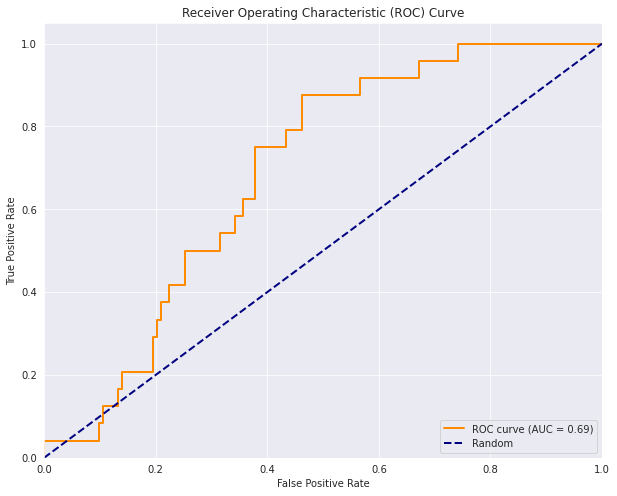

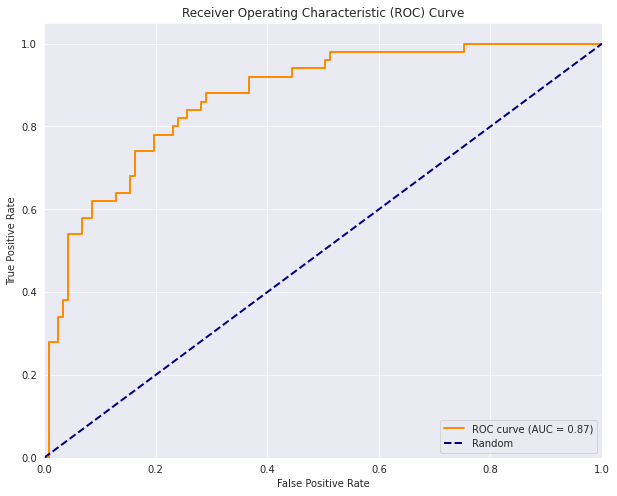

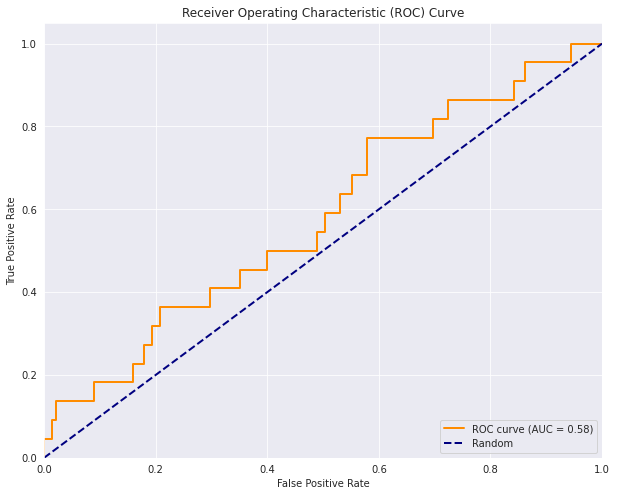

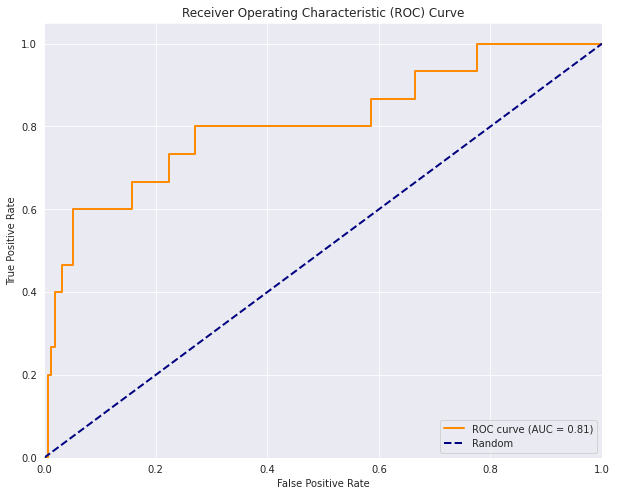

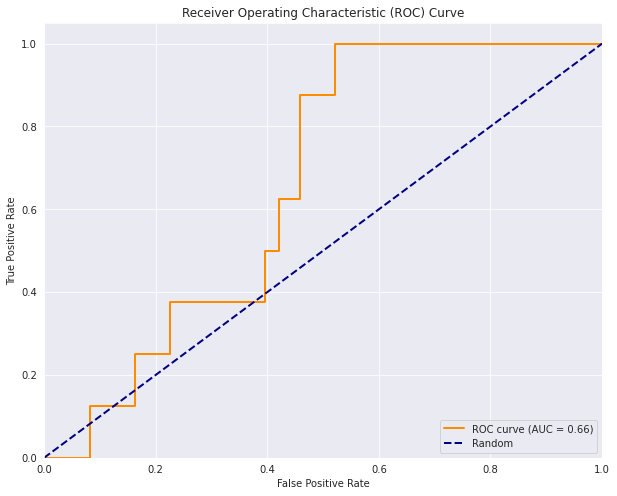

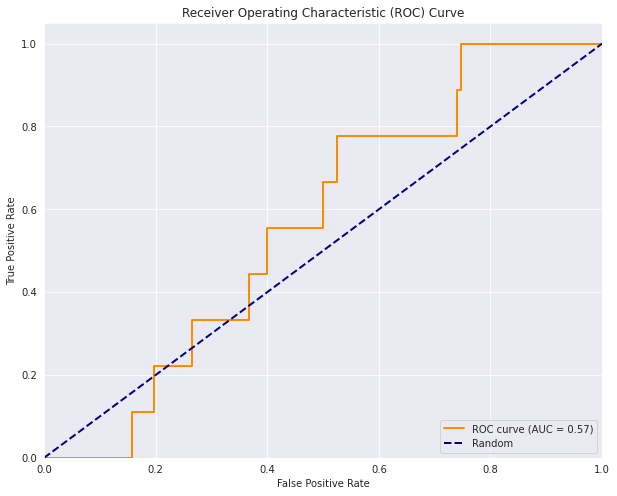

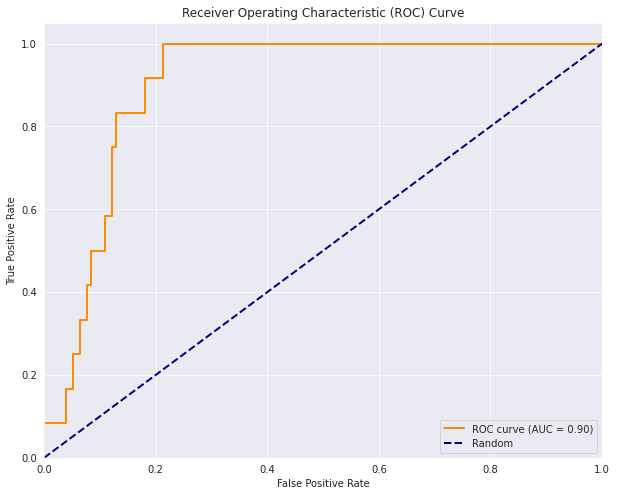

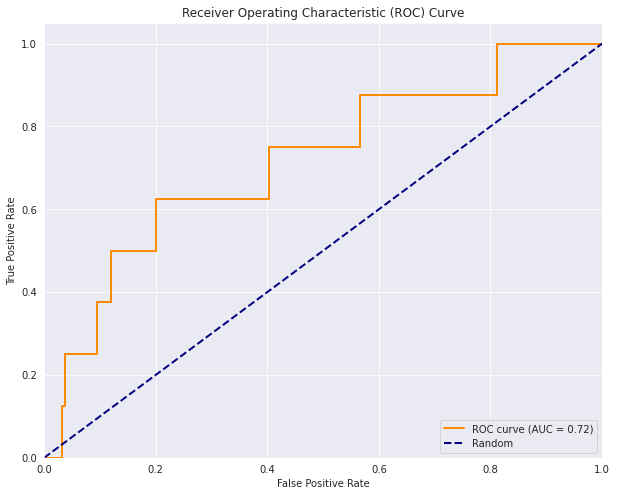

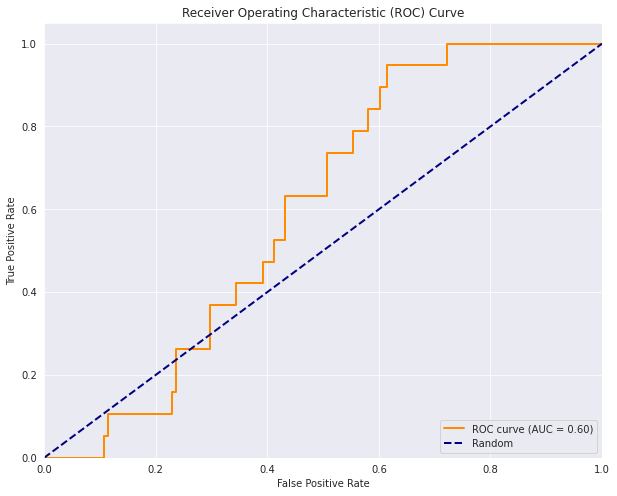

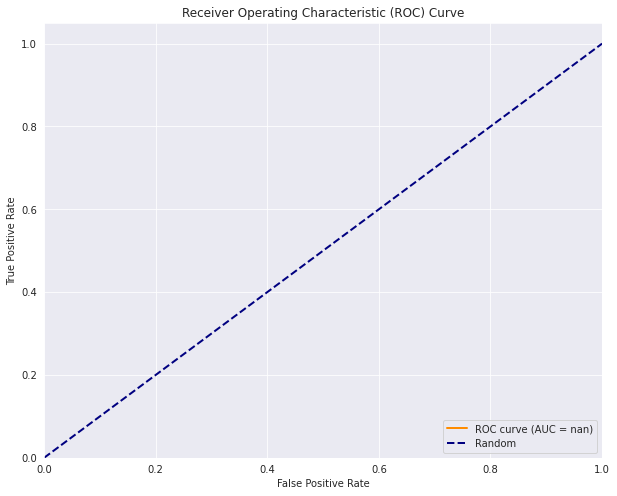

In [5]:
bias_idx = 3
class_idxs = np.arange(10)

aurocs_4 = []
    
for c in class_idxs:
    model = SFCN(output_dim=1, channel_number=[28, 58, 128, 256, 256, 64]).to('cuda')
    checkpoint = torch.load(f'checkpoints/study-SFCN-{bias_idx}-{c}/best_model.pt')
    model.load_state_dict(checkpoint['model_state_dict'])
    y_true, y_pred = test(model, '/data/Data/PD/test', bias_idx, c)
    aurocs_4.append(plot_auroc_curve(y_true, y_pred))

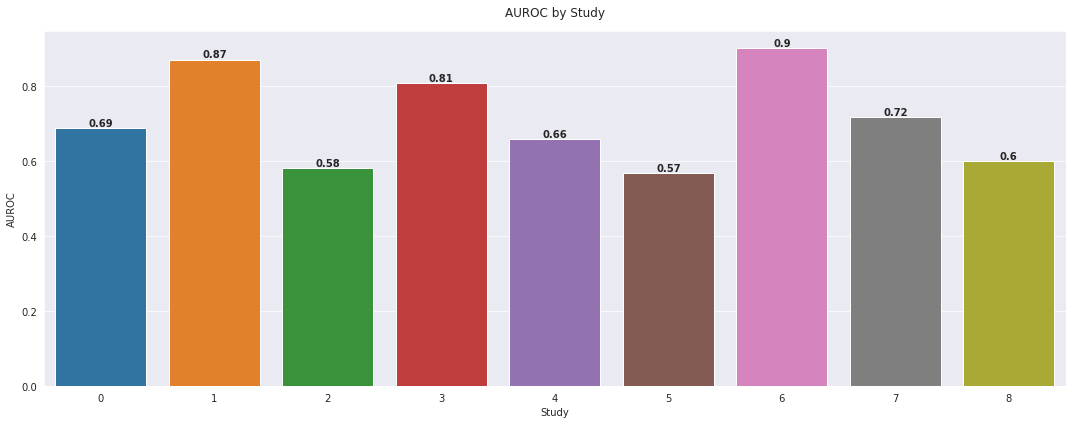

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from bias_registry import BiasRegistry
from textwrap import wrap

bias_registry = BiasRegistry()
# Create figure and axes
plt.figure(figsize=(15, 6))

# Create barplot
bar_plot = sns.barplot(x=np.arange(9), y=aurocs_4)

# Customize the plot
plt.title('AUROC by Study', pad=15)
plt.xlabel('Study')
plt.ylabel('AUROC')

# Add value labels on top of each bar
for i, v in enumerate(aurocs_4):
    bar_plot.text(
        i,                      # X position
        v,                      # Y position
        str(round(v,2)),                 # Text (value)
        ha='center',           # Horizontal alignment
        va='bottom',           # Vertical alignment
        fontweight='bold'      # Make the text bold
    )

# Adjust layout to prevent label cutoff
plt.tight_layout()


plt.savefig('/data/Papers/MICCAI-biases/split/study.pdf')